In [29]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nfl_data_py as nfl
from explore import summarize_df, check_missing_values
from transform import filter_to_plays, aggregate_df, add_calc_stats
from model import linreg_evaluate, optimize_alpha, rf_model_evaluate, logreg_model_evaluate

ImportError: cannot import name 'logreg_model_evaluate' from 'model' (c:\Users\alrec\Desktop\DATCAP Repo\DAT-Capstone\model.py)

In [2]:
years = list(range(2003, 2024))
columns =   ['play_id', 'game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type',
             'side_of_field', 'yardline_100', 'game_date', 'game_seconds_remaining', 'down', 'ydsnet', 'desc',
             'play_type', 'yards_gained', 'pass_length', 'yards_after_catch', 'field_goal_result', 
             'kick_distance', 'extra_point_result', 'two_point_conv_result', 'total_home_score', 
             'total_away_score', 'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 
             'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'wp', 'def_wp', 'home_wp', 
             'away_wp', 'wpa', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 
             'total_away_pass_wpa', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
             'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
             'fourth_down_failed', 'incomplete_pass', 'touchback', 'interception', 'fumble_forced', 
             'fumble_not_forced', 'fumble_out_of_bounds', 'safety', 'penalty', 'fumble_lost', 'rush_attempt', 
             'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 
             'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 
             'punt_attempt', 'fumble', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 
             'return_yards', 'penalty_team', 'penalty_yards', 'penalty_type', 'season', 'series_result', 
             'weather', 'play_type_nfl', 'special_teams_play', 'drive_first_downs', 
             'drive_inside20', 'drive_ended_with_score', 'away_score', 'home_score', 'location', 
             'result', 'total', 'spread_line', 'total_line', 'surface', 'temp', 'wind', 'pass', 
             'rush', 'first_down', 'special', 'play', 'qb_epa']
df = nfl.import_pbp_data(years, columns, downcast=True)

2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
summarize_df(df, display_rows=10)


First 10 rows:
   play_id          game_id home_team away_team season_type  week posteam  \
0      1.0  2003_01_ARI_DET       DET       ARI         REG     1    None   
1     35.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
2     57.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
3     78.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
4     99.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
5    120.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
6    141.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
7    160.0  2003_01_ARI_DET       DET       ARI         REG     1     DET   
8    178.0  2003_01_ARI_DET       DET       ARI         REG     1     ARI   
9    199.0  2003_01_ARI_DET       DET       ARI         REG     1     ARI   

  posteam_type side_of_field  yardline_100  ... offense_players  \
0         None          None           NaN  ...             NaN   
1 

In [4]:
check_missing_values(df, display_rows=500)

                    Column  NA_Count
0    two_point_conv_result    995563
1        field_goal_result    975894
2       extra_point_result    971013
3             penalty_type    926828
4             penalty_team    926808
..                     ...       ...
120                surface         0
121                home_wp         0
122                   pass         0
123                   rush         0
124                play_id         0

[125 rows x 2 columns]


,Column,NA_Count
0,two_point_conv_result,995563
1,field_goal_result,975894
2,extra_point_result,971013
3,penalty_type,926828
4,penalty_team,926808
...,...,...
120,surface,0
121,home_wp,0
122,pass,0
123,rush,0


In [5]:
filtered_df = filter_to_plays(df)

encoded_df = pd.get_dummies(filtered_df, columns=['field_goal_result',
                                         'extra_point_result',
                                         'two_point_conv_result'], 
                                         drop_first=True)

group_by = ['game_id', 'posteam', 'home_team', 'away_team']

column_functions = {'yards_gained': 'sum',
                    'receiving_yards': 'sum',
                    'rushing_yards': 'sum',
                    'return_yards': 'sum',
                    'incomplete_pass': 'sum',
                    'complete_pass': 'sum',
                    'interception': 'sum',
                    'pass_attempt': 'sum',
                    'rush_attempt': 'sum',
                    'touchdown': 'sum',
                    'pass_touchdown': 'sum',
                    'rush_touchdown': 'sum',
                    'return_touchdown': 'sum',
                    'first_down': 'sum',
                    'play': 'sum',
                    'sack': 'sum',
                    'fumble': 'sum',
                    'fumble_lost': 'sum',
                    'field_goal_result_made': 'sum',
                    'field_goal_result_missed': 'sum',
                    'extra_point_result_good': 'sum',
                    'extra_point_result_failed': 'sum',
                    'safety': 'sum',
                    'total_home_epa': 'max',
                    'total_away_epa': 'max',
                    'total_home_score': 'max',
                    'total_away_score': 'max',
                    'total': 'max'}

df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

aggregated_df = aggregate_df(encoded_df, group_by, df_column_functions)

transformed_df = add_calc_stats(aggregated_df, encoded_df)

c:\Users\alrec\Desktop\DATCAP Repo\transform.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [26]:
features = ['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
            'first_down_rate_allowed', 'turnover_differential']
target_variable = 'win_percentage_season'

X = transformed_df[features]
y = transformed_df[target_variable]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_evaluate(linreg_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
R² Score: 0.14
                   Feature  Coefficient
1  first_down_rate_offense     0.846903
3  first_down_rate_allowed    -0.337724
2   yards_per_play_allowed    -0.013324
4    turnover_differential     0.012198
0   yards_per_play_offense     0.012127


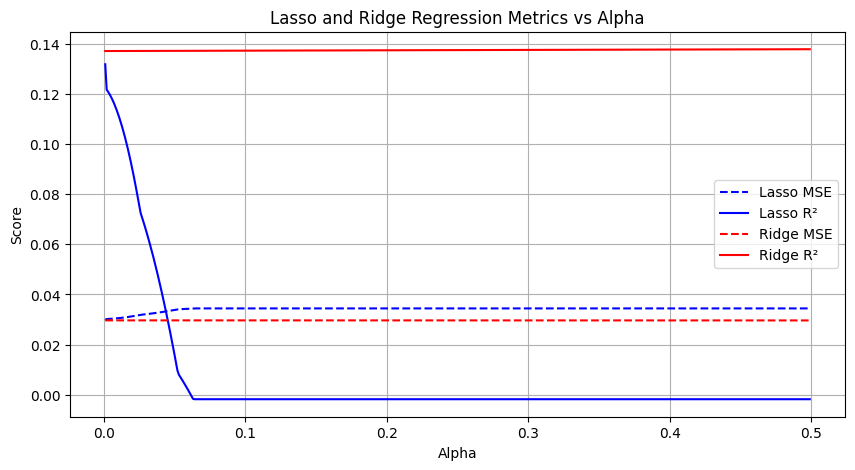

In [19]:
optimize_alpha(mode='both', features_train=X_train, target_train=y_train, features_test=X_test, target_test=y_test)

In [20]:
ridge_model = Ridge(alpha=.05)
ridge_model.fit(X_train, y_train)
linreg_evaluate(ridge_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
R² Score: 0.14
                   Feature  Coefficient
1  first_down_rate_offense     0.843858
3  first_down_rate_allowed    -0.336302
2   yards_per_play_allowed    -0.013365
0   yards_per_play_offense     0.012233
4    turnover_differential     0.012199


In [21]:
lasso_model = Lasso(alpha=.01)
lasso_model.fit(X_train, y_train)
linreg_evaluate(lasso_model, features_test = X_test, target_test = y_test)

Mean Squared Error: 0.03
R² Score: 0.11
                   Feature  Coefficient
0   yards_per_play_offense     0.033386
2   yards_per_play_allowed    -0.013692
4    turnover_differential     0.011164
1  first_down_rate_offense     0.000000
3  first_down_rate_allowed    -0.000000


In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model_evaluate(rf_model, features_test=X_test, target_test=y_test, tree_plot=True, feature_importance=True)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_model_evaluate(logreg_model, X_test, y_test)

In [11]:
print("Would you like to save any files from the project? (y/n)")
i = input("").strip()
if i in {'Y', 'y', 'ex'}:
    print("Would you like to save the models to a folder? (y/n)")
    print("ex = 'C:\\Users\\alrec\\Desktop\\DATCAP Repo\\models'")
    i = input("").strip()
    
    if i in {'Y', 'y', 'ex'}:
        if i == 'ex':
            filepath = r'C:\Users\alrec\Desktop\DATCAP Repo\models'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ").strip()
        
        os.makedirs(filepath, exist_ok=True)
        joblib.dump(linreg_model, os.path.join(filepath, 'linreg_model.pkl'))
        joblib.dump(ridge_model, os.path.join(filepath, 'ridge_model.pkl'))
        joblib.dump(lasso_model, os.path.join(filepath, 'lasso_model.pkl'))
        joblib.dump(rf_model, os.path.join(filepath, 'rf_model.pkl'))
        print('Models saved successfully')
    
    print("Would you like to save the data to a folder? (y/n)")
    i = input("").strip()
    
    if i in {'Y', 'y', 'ex'}:
        if i == 'ex':
            filepath = r'C:\Users\alrec\Desktop\DATCAP Repo\data'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ").strip()
        
        os.makedirs(filepath, exist_ok=True)
        
        df.to_csv(os.path.join(filepath, 'df.csv'), index=False)
        filtered_df.to_csv(os.path.join(filepath, 'filtered_df.csv'), index=False)
        aggregated_df.to_csv(os.path.join(filepath, 'aggregated_df.csv'), index=False)
        transformed_df.to_csv(os.path.join(filepath, 'transformed_df.csv'), index=False)

        print('Data saved successfully')


Would you like to save any files from the project? (y/n)
